<a href="https://colab.research.google.com/github/samuelecivale/Lab-Iagi/blob/main/Esercitazione_8_Quick%2C_Draw!_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Esercitazione 8 - CNN-based "Quick, draw!"

Il vostro mandato è quello di implementare e addestrare un classificatore di disegni utilizzando il dataset descritto sopra. In particolare dovrete assicurarvi che la vostra soluzione abbia le seguenti caratteristiche:

1. Dovrete utilizzare una rete backbone di quelle viste a lezione, preaddestrata su ImageNet, e fare transfer learning per questo problema.
2. Il dataset è troppo grande per essere gestito tutto in un computer portatile (a meno che non abbiate qualcosa di veramente fuori dal comune), quindi dovrete scegliere un numero inferiore di classi a vostra discrezione, ma non meno di 30. Inoltre devono essere incluse le seguenti classi: camel, dog, face, horse, ice cream, moon, microphone, onion, pillow, potato, pond e pool. Potete diecidere voi se lavorare con immagini 256x256 o 28x28.
3. Dovete scrivere una classe pytorch Dataset da utilizzare nel Dataloader, come avete visto nelle esercitazioni precedenti.
4. Dovete arrivare ad avere un sistema addestrato che non sia in overfitting o underfitting.
5. Dovete dimostrare l'esplorazione di almeno due iperparametri, tra cui la learning rate, con esplorazione randomica.
6. Dovrete effettuare una failure analysis finale per essere capaci di discutere cosa il vostro sistema sa, o non sa fare.

Questi sono i requisiti minimi, ma se volete spingervi oltre, potete sbizzarrivi (esplorare diverse architetture, confrontare le performance di sistemi addestrati da zero, addestrare su tutte le classi, etc...).

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy
from matplotlib_inline.backend_inline import set_matplotlib_formats
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from collections import OrderedDict
from sklearn.metrics import accuracy_score

In [2]:
def set_seed(seed):
    """
    Imposta il seed per la generazione casuale e l'inizializzazione dei pesi per garantire la riproducibilità.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Using device cuda:0


In [3]:
!gsutil -m cp \
  "gs://quickdraw_dataset/full/numpy_bitmap/camel.npy" \
  "gs://quickdraw_dataset/full/numpy_bitmap/dog.npy" \
  "gs://quickdraw_dataset/full/numpy_bitmap/face.npy" \
  "gs://quickdraw_dataset/full/numpy_bitmap/horse.npy" \
  "gs://quickdraw_dataset/full/numpy_bitmap/moon.npy" \
  .

"""
 scarico dai bucket di google le categorie, ne scarico 5 sennò mi si satura la RAM
"""


Copying gs://quickdraw_dataset/full/numpy_bitmap/camel.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/dog.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/face.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/horse.npy...
Copying gs://quickdraw_dataset/full/numpy_bitmap/moon.npy...
\ [5/5 files][549.7 MiB/549.7 MiB] 100% Done                                    
Operation completed over 5 objects/549.7 MiB.                                    


'\n scarico dai bucket di google le categorie, ne scarico 5 sennò mi si satura la RAM\n'

In [4]:
import numpy as np

# Elenco delle categorie da caricare
categories = [
    'camel',
    'dog', 'face', 'horse', 'moon'
]

# Dizionario di etichette
label_dict = {category: idx for idx, category in enumerate(categories)}

# Carica dati per ciascuna categoria
classes = {}
file_path = '/content/'  # Cambia il percorso a seconda di dove hai salvato la cartella "dataset"

for category in categories:
    file_name = category + ".npy"
    data = np.load(file_path + file_name)

    data = np.c_[data, label_dict[category] * np.ones(len(data))]
    classes[category] = data
    print(classes[category].shape)


(121399, 785)
(152159, 785)
(161666, 785)
(178286, 785)
(121661, 785)


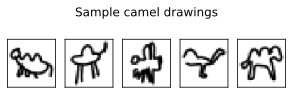

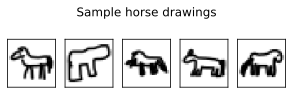

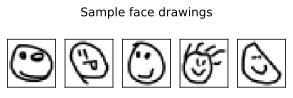

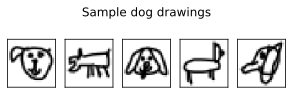

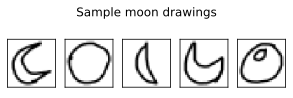

In [5]:
def plot_samples(input_array, rows=1, cols=5, title=''):
    """
    Visualizza un insieme di campioni di disegni da un array di input.

    Parameters:
    - input_array (numpy.ndarray): Array contenente i dati da visualizzare.
    - rows (int): Numero di righe nella griglia di visualizzazione.
    - cols (int): Numero di colonne nella griglia di visualizzazione.
    - title (str): Titolo della visualizzazione.

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

# Plot samples
plot_samples(classes['camel'], title='Sample camel drawings\n')
plot_samples(classes['horse'], title = 'Sample horse drawings\n')
plot_samples(classes['face'], title = 'Sample face drawings\n')
plot_samples(classes['dog'], title = 'Sample dog drawings\n')
plot_samples(classes['moon'], title = 'Sample moon drawings\n')

In [6]:
#Let's create a dataset
import torch.utils.data as data

class QDrawDataset(data.Dataset):

    def __init__(self,size=10000):
        super().__init__()
        self.size = size
        self.generate_dataset()

    def generate_dataset(self):
      # Genera il dataset concatenando i dati delle diverse categorie.


        X = np.concatenate((classes['camel'][:self.size,:-1],
                            classes['dog'][:self.size,:-1],
                            classes['face'][:self.size,:-1],
                            classes['horse'][:self.size,:-1],
                            classes['moon'][:self.size,:-1]), axis=0).astype('float64') # all columns but the last

        y = np.concatenate((classes['camel'][:self.size,-1],
                            classes['dog'][:self.size,-1],
                            classes['face'][:self.size,-1],
                            classes['horse'][:self.size,-1],
                            classes['moon'][:self.size,-1]), axis=0).astype('int') # the last column

        X = torch.from_numpy(X)
        y = torch.from_numpy(y)

        self.data = X.double()
        self.label = y

    def __len__(self):
      # Restituisce la lunghezza del dataset.

        return self.label.shape[0]

    def __getitem__(self, idx):
        """
        Restituisce il punto dati dell'indice specificato.

        Parameters:
        - idx (int): L'indice del punto dati.

        Returns:
        tuple: Una tupla contenente i dati del punto e la sua etichetta.
        """
        data_point = (self.data[idx]/255.).reshape(1,28,28)
        data = np.concatenate((data_point, data_point, data_point), axis=0)
        data_label = self.label[idx]
        return data, data_label

In [7]:
dataset = QDrawDataset(size=12000)
print("Size of dataset:", len(dataset))
print("Size of datapoint:", dataset[0][0].shape)
print("Data point 0:", dataset[0])

Size of dataset: 60000
Size of datapoint: (3, 28, 28)
Data point 0: (array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]]), tensor(0))


In [8]:
"""
Inizializzamo i set di train e di validation
"""

set_seed(42)
train_set, test_set = data.random_split(dataset, [50000, 10000])
set_seed(42)
train_set, val_set = data.random_split(train_set, [35000, 15000])

"""
indica che ogni batch conterrà 128 campioni.
shuffle=True implica che i dati vengono mescolati all'inizio di ogni epoca.
drop_last=True significa che l'ultimo batch verrà scartato se la dimensione del dataset non è divisibile per il batch size.
num_workers=2 specifica il numero di processi paralleli utilizzati per caricare i dati.
"""

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=2)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=True, num_workers=2)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)


In [9]:
"""
Questo codice utilizza la funzione next(iter(...)) per ottenere il primo batch dai dataloader (val_loader in questo caso)
e quindi stampa le dimensioni e i dati del batch.
"""
data_inputs, data_labels = next(iter(val_loader))

"""
Le dimensioni degli output sono [batch_size, d_1,...,d_N] dove d_1,...,d_N sono le
dimensioni del punto dati restituito dalla classe del dataset
"""
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([128, 3, 28, 28]) 
 tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
       

In [10]:
"""
Questo codice definisce un modello ResNet-50 preaddestrato (model) utilizzando i pesi di default.
Successivamente, il modello è spostato sulla GPU se disponibile (model = model.to(device)).
Vengono anche definiti un ottimizzatore SGD (optimizer) e una funzione di loss (criterion).
"""

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#Crea un ottimizzatore SGD (Stochastic Gradient Descent) che ottimizzerà i parametri del modello con un tasso di apprendimento di 0.01.
criterion = nn.CrossEntropyLoss()
#Definisce la loss function come la CrossEntropyLoss, comunemente utilizzata per problemi di classificazione.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


In [11]:
def train(epoch, log_interval=200):
    """
    Esegue un'epoca di addestramento del modello.

    Parameters:
    - epoch (int): Numero dell'epoca corrente.
    - log_interval (int): Intervallo di iterazioni tra le stampe di log.

    Returns:
    None
    """
    # Imposta il modello in modalità di addestramento
    model.train()

    # Itera su ciascun batch dal set di addestramento
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copia i dati sulla GPU se necessario
        data = data.to(device)
        target = target.to(device)

        # Azzera i buffer del gradiente
        optimizer.zero_grad()

        # Fai passare i dati attraverso la rete neurale
        model.double()  # Imposta il modello in doppia precisione
        preds = model(data)
        preds = preds.squeeze(dim=1)

        # Calcola la loss
        loss = criterion(preds, target)

        # Backpropagation
        loss.backward()

        # Aggiorna i pesi
        optimizer.step()

        # Stampa log ogni log_interval iterazioni
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))


In [12]:
def validate(loss_vec, acc_vec, log_interval=200):
    """
    Funzione di validazione del modello.

    Parameters:
    - loss_vec (list): Lista per memorizzare i valori di loss.
    - acc_vec (list): Lista per memorizzare i valori di accuratezza.
    - log_interval (int): Intervallo di iterazioni tra le stampe di log.

    Returns:
    None
    """
    valid_loss = 0.0
    num_batches = 0
    running_corrects = 0
    model.eval()

    for batch_idx, (data, labels) in enumerate(val_loader):
        data = data.to(device)
        labels = labels.to(device)

        num_batches += 1

        target = model(data)

        _, preds = torch.max(target, 1)

        loss = criterion(target, labels)

        valid_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if batch_idx % log_interval == 0:
            print('Validation: [{}/{} ({:.0f}%)]'.format(
                batch_idx * len(data), len(val_loader.dataset),
                100. * batch_idx / len(val_loader)))

    epoch_loss = valid_loss / (128 * num_batches)
    epoch_acc = running_corrects.double() / (128 * num_batches)
    epoch_acc = epoch_acc.cpu()

    # Aggiorna i vettori di loss e accuratezza
    loss_vec.append(epoch_loss)
    acc_vec.append(epoch_acc)

    print('Validation set: Average loss: {:.4f}, Average acc: {:.4f}\n'.format(
        epoch_loss, epoch_acc))


In [13]:
%%time
epochs = 5

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, log_interval=40)
    validate(lossv, accv, log_interval=80)

Train Epoch: 1 [0/35000 (0%)]	Loss: 11.379012
Train Epoch: 1 [5120/35000 (15%)]	Loss: 5.720855
Train Epoch: 1 [10240/35000 (29%)]	Loss: 2.980641
Train Epoch: 1 [15360/35000 (44%)]	Loss: 0.962336
Train Epoch: 1 [20480/35000 (59%)]	Loss: 1.281925
Train Epoch: 1 [25600/35000 (73%)]	Loss: 0.752016
Train Epoch: 1 [30720/35000 (88%)]	Loss: 0.836270
Validation: [0/15000 (0%)]
Validation: [10240/15000 (68%)]
Validation set: Average loss: 0.5878, Average acc: 0.8060

Train Epoch: 2 [0/35000 (0%)]	Loss: 0.525053
Train Epoch: 2 [5120/35000 (15%)]	Loss: 0.521203
Train Epoch: 2 [10240/35000 (29%)]	Loss: 0.512709
Train Epoch: 2 [15360/35000 (44%)]	Loss: 0.459144
Train Epoch: 2 [20480/35000 (59%)]	Loss: 0.443727
Train Epoch: 2 [25600/35000 (73%)]	Loss: 0.474266
Train Epoch: 2 [30720/35000 (88%)]	Loss: 0.440808
Validation: [0/15000 (0%)]
Validation: [10240/15000 (68%)]
Validation set: Average loss: 0.4062, Average acc: 0.8537

Train Epoch: 3 [0/35000 (0%)]	Loss: 0.345355
Train Epoch: 3 [5120/35000 (15

Loss di Addestramento vs Loss di Validazione:

La loss di addestramento è in diminuzione, il che indica che il modello sta apprendendo dai dati di addestramento.
La loss di validazione è anche in diminuzione, il che è un segno positivo. Indica che il modello sta generalizzando bene anche su dati non visti.
Accuratezza di Addestramento vs Accuratezza di Validazione:

L'accuratezza di addestramento sembra essere alta (0.8716) nella tua ultima epoca.
L'accuratezza di validazione è anche buona (0.8716) e segue una traiettoria simile a quella della loss di validazione.
Confronto tra Loss di Addestramento e Loss di Validazione:

La loss di validazione è inferiore rispetto alla loss di addestramento, il che è un buon segno di generalizzazione. Tuttavia, questo potrebbe essere dovuto anche a diverse scale di loss, quindi vale la pena esaminare più da vicino.

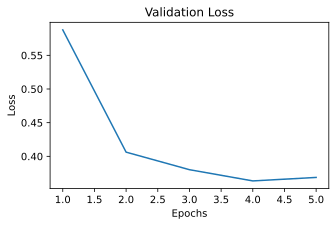

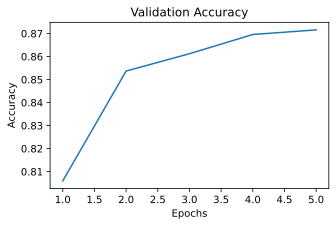

In [14]:
import matplotlib.pyplot as plt

# Plot della loss di validazione
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), lossv)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot dell'accuratezza di validazione
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, epochs + 1), accv)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


Non ho eseguito il tuning degli iperparametri poichè eccedeva nell'utilizzo della ram e non finiva prima delle 2 ore

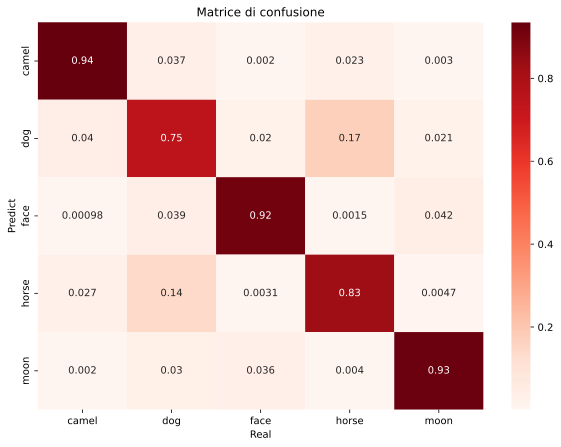

In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Trasferisci i dati sulla GPU, se disponibile
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())  # Trasferisci nuovamente le previsioni sulla CPU
        all_labels.extend(labels.cpu().numpy())  # Trasferisci nuovamente le etichette sulla CPU

conf_matrix = confusion_matrix(all_labels, all_preds)
class_percentages = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(class_percentages, index=categories, columns=categories)

# Specifica una mappa di colori personalizzata (in questo caso, toni rossi)
pippo = sns.color_palette("Reds", as_cmap=True)

# Crea il plot della matrice di confusione con la mappa di colori personalizzata
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap=pippo)

# Personalizza l'etichetta degli assi
plt.xlabel("Real")
plt.ylabel("Predict")
plt.title("Matrice di confusione")
# Mostra il plot
plt.show()
